**IMPORTING REQUIRED LIBRARIES**

In [0]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import keras
import keras as k
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Dense, Dropout, Activation,Flatten,BatchNormalization,regularizers
from keras.layers import Conv2D,ZeroPadding2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns
from keras.utils import to_categorical
from keras.constraints import unit_norm
import matplotlib as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.2MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1wqettYpiQzofksPUZRGY8c0sDwXdqumI'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1wqettYpiQzofksPUZRGY8c0sDwXdqumI


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
edgar = pd.read_json('Filename.csv')

**LOADING IMDB DATA FOR TRAINING**

Data: contains 2 labels positive and negative

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (2).csv


In [0]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe


In [0]:
train.head()

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0
3,It's a strange feeling to sit alone in a theat...,0
4,"You probably all already know this by now, but...",0


**CLEANING DATA BY REMOVING STOP WORDS, PUNCTUATIONS, ETC**

In [0]:
def review_to_words( raw_review ):
    
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words )) 

In [0]:
num_reviews = 25000
clean_train_reviews = []
for i in range( 0, num_reviews ):
    clean_train_reviews.append( review_to_words( train["text"][i] ) )

**CREATING BAG OF WORDS **

In [0]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()
print (train_data_features.shape)

Creating the bag of words...

(25000, 1000)


**SPLIT DATA INTO TRAIN AND TEST WITH 80:20 RATIO**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_data_features, train['sentiment'], test_size = 0.20, random_state = 0)

In [0]:
n = x_val.shape[1]
print(y_val.shape)
print(y_train.shape)

(5000,)
(20000,)


In [0]:
print(x_train.shape)
print(y_train.shape)

(20000, 1000)
(20000,)


**MODEL CREATION**

In [0]:
model = Sequential()
model.add(Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(1000,)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=regularizers.l1(0.001),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
NumEpochs = 50
BatchSize = 512

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 3s 151us/step - loss: 1.1701 - acc: 0.5626 - val_loss: 0.9753 - val_acc: 0.7336
Epoch 2/50
20000/20000 [==============================] - 0s 15us/step - loss: 0.8870 - acc: 0.6660 - val_loss: 0.7378 - val_acc: 0.8152
Epoch 3/50
20000/20000 [==============================] - 0s 15us/step - loss: 0.7351 - acc: 0.7224 - val_loss: 0.6286 - val_acc: 0.8268
Epoch 4/50
20000/20000 [==============================] - 0s 16us/step - loss: 0.6591 - acc: 0.7683 - val_loss: 0.5866 - val_acc: 0.8232
Epoch 5/50
20000/20000 [==============================] - 0s 16us/step - loss: 0.6190 - acc: 0.7858 - val_loss: 0.5458 - val_acc: 0.8374
Epoch 6/50
20000/20000 [==============================] - 0s 16us/step - loss: 0.5926 - acc: 0.8030 - val_loss: 0.5195 - val_acc: 0.8412
Epoch 7/50
20000/20000 [==============================] - 0s 17us/step - loss: 0

**MODEL PERFORMANCE**

In [0]:
acc = model.evaluate(x_val, y_val, verbose=1)
print('Test data loss:', acc[0] )
print('Test data accuracy:', acc[1] * 100)

5000/5000 [==============================] - 0s 59us/step
Test data loss: 0.465498833322525
Test data accuracy: 85.11999999999999


**SAVING BEST MODEL**

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(".\\Models\\imdb_bow.h5", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


**TRANSFER LEARNING USING FINANCE DATA**

In [0]:
edgar.head()

,sentiment,text
0,positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,positive,Stock-based compensation totaled $2.3 billion....
10,negative,"For the full-year 2018, Other Bets revenues we..."
100,neutral,Great. Thank you. I just wanted to follow up o...
1000,negative,I have made it a priority to join Mike and Reb...


In [0]:
# Convert sentiments into 0,1,2
sent = {'positive': 1,'negative': 0,'neutral': 2} 
edgar.sentiment = [sent[item] for item in edgar.sentiment] 

**Preprocess the edgar text data**

In [0]:
num_reviews = 1649

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( edgar["text"][i] ) )

In [0]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

# see final the clean data
print (train_data_features.shape)

Creating the bag of words...

(1649, 1000)


In [0]:
Y = pd.get_dummies(edgar['sentiment']).values
X =train_data_features

In [0]:
print(Y.shape)
print(X.shape)

(1649, 3)
(1649, 1000)


In [0]:
from keras.models import model_from_json
# load json and create model
json_file = open(".\\Models\\imdb_bow.h5", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
for layer in loaded_model.layers:
  layer.trainable = True

In [0]:

model1 = Sequential()
for layer in loaded_model.layers[:-1]:
    model1.add(layer)
    
model1.add(Dense(3,activation='softmax'))

In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                16016     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 16,339
Trainable params: 16,339
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [0]:
print('Test Evaluation with finance data')
evaluation = model1.evaluate(X,Y, batch_size=64)
print('Loss:', evaluation[0], 'Accuracy:', evaluation[1])

Test Evaluation with finance data
1649/1649 [==============================] - 0s 104us/step
Loss: 0.7475845147581661 Accuracy: 0.6674752566147891


**Prediction using the Pre-Trained Model**

In [0]:
Prediction_bow = model1.predict(X)

In [0]:
for i in range(0,len(Prediction_bow)):
  y = Prediction_bow[i]
  max = np.argmax(y)
  min = np.argmin(y)
  for x in range(0,2):
    y[max]=1
    y[min]=0
    if y[x]!=0 and y[x]!=1:
      y[x]=0

In [0]:
for r in Prediction_bow:
  maxValueIndex =r.argmax()
  #print(maxValueIndex)
  r[0] = 0.0
  r[1] = 0.0
  r[2] = 0.0
  r[maxValueIndex] = 1.0

**CONFUSION MATRIX**

In [0]:
cm = confusion_matrix(Y.argmax(axis=1), Prediction_bow.argmax(axis =1)) 
print('Confusion Matrix :')
print(cm) 

Confusion Matrix :
[[  0  19 139]
 [  0  68 592]
 [  0 116 715]]


[]

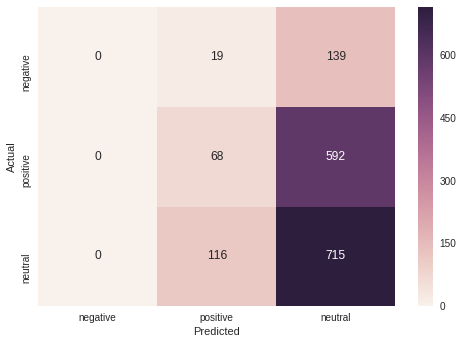

In [0]:
LABELS = ['negative', 'positive','neutral']
a = sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
a.set(xlabel='Predicted', ylabel='Actual')
a.plot()
# xl = plt.xlabel("Predicted")

# yl = plt.ylabel("Actual")